In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.preprocessing import image                  
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator


# Preparation

In [11]:
#ID for the model
model_name = "final_map"

The following defines functions to load train, test, and validation dataset (adapted from dog-cnn assignment)

In [5]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 250)
    return files, targets

def path_to_tensor(img_path,shape):
    img = image.load_img(img_path, target_size=shape,grayscale=True)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths,shape):
    list_of_tensors = [path_to_tensor(img_path,shape) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)



In [6]:
#load folder
X, y = load_dataset('png')
#split data
X_train, X_Test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=123)
test_n = int(len(X_Test)/2)
X_Val = X_Test[test_n:]
y_val = y_test[test_n:]
X_Test = X_Test[:test_n]
y_test = y_test[:test_n]


In [7]:
#size of images
shape = (256, 256) 

#create tensors
train_tensors = paths_to_tensor(X_train,shape).astype('float32')/255
valid_tensors = paths_to_tensor(X_Val,shape).astype('float32')/255
test_tensors = paths_to_tensor(X_Test,shape).astype('float32')/255


100%|██████████| 2000/2000 [00:05<00:00, 391.81it/s]


# Data Augmentation

In [9]:
# setup data generator for Data Augmentation
datagen = ImageDataGenerator(
              width_shift_range=0.2,
              height_shift_range=0.2,
              horizontal_flip = True,
              zoom_range = 0.2
  )

datagen.fit(train_tensors)



In [10]:
# Initialize  and compile CNN


#CNN 
model = Sequential()
model.add(Conv2D(filters=16,kernel_size=4, padding='same',activation='relu',input_shape=train_tensors.shape[1:]))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=4, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=4, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128,kernel_size=4, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256,kernel_size=4, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(250,activation='softmax'))
model.summary()


model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      272       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       131200    
__________

# Training

In [12]:
from keras.callbacks import ModelCheckpoint  

epochs = 80
#checkpoint
checkpointer = ModelCheckpoint(filepath=model_name+'.hdf5', 
                               verbose=1, save_best_only=True)

#batch size
bs = 32

history = model.fit_generator(datagen.flow(train_tensors,y_train,batch_size=bs),steps_per_epoch=train_tensors.shape[0]/bs,
                                  epochs=epochs, verbose=1,callbacks=[checkpointer],validation_data=(valid_tensors, y_val)
    )

model.load_weights(model_name+'.hdf5')



Epoch 1/80
500/500 [==============================] - 53s - loss: 5.5283 - acc: 0.0032 - val_loss: 5.5148 - val_acc: 0.0035
Epoch 2/80
500/500 [==============================] - 51s - loss: 5.3861 - acc: 0.0116 - val_loss: 5.1227 - val_acc: 0.0180
Epoch 3/80
500/500 [==============================] - 51s - loss: 5.0145 - acc: 0.0285 - val_loss: 4.6996 - val_acc: 0.0745
Epoch 4/80
500/500 [==============================] - 51s - loss: 4.5386 - acc: 0.0794 - val_loss: 4.1118 - val_acc: 0.1255
Epoch 5/80
500/500 [==============================] - 51s - loss: 4.0517 - acc: 0.1372 - val_loss: 3.5876 - val_acc: 0.2285
Epoch 6/80
500/500 [==============================] - 51s - loss: 3.6730 - acc: 0.2003 - val_loss: 3.1973 - val_acc: 0.2900
Epoch 7/80
500/500 [==============================] - 52s - loss: 3.3437 - acc: 0.2629 - val_loss: 2.9977 - val_acc: 0.3380
Epoch 8/80
500/500 [==============================] - 52s - loss: 3.0845 - acc: 0.3064 - val_loss: 2.8605 - val_acc: 0.3760
Epoch 9/

500/500 [==============================] - 50s - loss: 1.7339 - acc: 0.5747 - val_loss: 1.7896 - val_acc: 0.6005
Epoch 29/80
500/500 [==============================] - 50s - loss: 1.7257 - acc: 0.5766 - val_loss: 1.7814 - val_acc: 0.6030
Epoch 30/80
500/500 [==============================] - 50s - loss: 1.7060 - acc: 0.5819 - val_loss: 1.6647 - val_acc: 0.6130
Epoch 31/80
500/500 [==============================] - 50s - loss: 1.6788 - acc: 0.5850 - val_loss: 1.6130 - val_acc: 0.6200
Epoch 32/80
500/500 [==============================] - 50s - loss: 1.6704 - acc: 0.5914 - val_loss: 1.6284 - val_acc: 0.6135
Epoch 33/80
500/500 [==============================] - 50s - loss: 1.6672 - acc: 0.5936 - val_loss: 1.6909 - val_acc: 0.6065
Epoch 34/80
500/500 [==============================] - 52s - loss: 1.6300 - acc: 0.5932 - val_loss: 1.6779 - val_acc: 0.6045
Epoch 35/80
500/500 [==============================] - 52s - loss: 1.6307 - acc: 0.5989 - val_loss: 1.8025 - val_acc: 0.5975
Epoch 36/80


500/500 [==============================] - 52s - loss: 1.4236 - acc: 0.6392 - val_loss: 1.6188 - val_acc: 0.6310
Epoch 59/80
500/500 [==============================] - 52s - loss: 1.4224 - acc: 0.6401 - val_loss: 1.6817 - val_acc: 0.6255
Epoch 60/80
500/500 [==============================] - 51s - loss: 1.4209 - acc: 0.6391 - val_loss: 1.5546 - val_acc: 0.6445
Epoch 61/80
500/500 [==============================] - 51s - loss: 1.3925 - acc: 0.6461 - val_loss: 1.7311 - val_acc: 0.6295
Epoch 62/80
500/500 [==============================] - 52s - loss: 1.4098 - acc: 0.6414 - val_loss: 1.6047 - val_acc: 0.6390
Epoch 63/80
500/500 [==============================] - 51s - loss: 1.3994 - acc: 0.6431 - val_loss: 1.5558 - val_acc: 0.6265
Epoch 64/80
500/500 [==============================] - 51s - loss: 1.3793 - acc: 0.6465 - val_loss: 1.5653 - val_acc: 0.6100
Epoch 65/80
500/500 [==============================] - 51s - loss: 1.3682 - acc: 0.6559 - val_loss: 1.5199 - val_acc: 0.6445
Epoch 66/80


# Results

In [13]:
# make prediction
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(y_test, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)



Test accuracy: 66.3500%


# Visualization

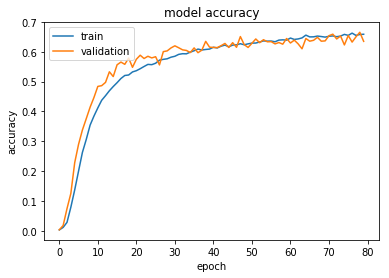

In [14]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

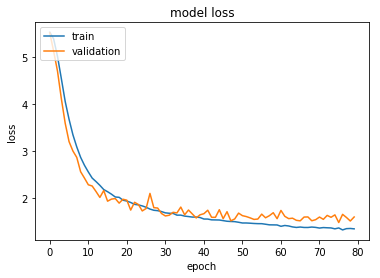

In [15]:
plt.gcf().clear()
#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()